In [47]:
# pip install jax

In [48]:
import pickle
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

from IPython.display import HTML
import jax
import matplotlib
from ipywidgets import widgets
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray
import matplotlib.pyplot as plt


In [49]:
# mesh坐标
with open('../graphcast-data/_mesh_nodes_lat.pkl', 'rb') as f:
    _mesh_nodes_lat = pickle.load(f)
with open('../graphcast-data/_mesh_nodes_lon.pkl', 'rb') as f:
    _mesh_nodes_lon = pickle.load(f)
# grid坐标
with open('../graphcast-data/_grid_lat.pkl', 'rb') as f:
    _grid_lat = pickle.load(f)
with open('../graphcast-data/_grid_lon.pkl', 'rb') as f:
    _grid_lon = pickle.load(f)
# 处理grid坐标
grid_lat, grid_lon = np.meshgrid(_grid_lat, _grid_lon)
flat_grid_lat = grid_lat.ravel()
flat_grid_lon = grid_lon.ravel()

with open('../graphcast-data/eval_inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('../graphcast-data/eval_forcings.pkl', 'rb') as f:
    forcings = pickle.load(f)
with open('../graphcast-data/eval_targets.pkl', 'rb') as f:
    eval_targets = pickle.load(f)
with open('../graphcast-data/predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)
with open('../graphcast-data/grid_node_features.pkl', 'rb') as f:
    grid_node_features = pickle.load(f)
with open('../graphcast-data/latent_mesh_nodes.pkl', 'rb') as f:
    latent_mesh_nodes = pickle.load(f)
with open('../graphcast-data/output_grid_nodes.pkl', 'rb') as f:
    output_grid_nodes = pickle.load(f)

# print("inputs")
# for var_name, var in inputs.data_vars.items():
#     print(f"变量名: {var_name}, 形状: {var.shape}")
# print("forcings")
# for var_name, var in forcings.data_vars.items():
#     print(f"变量名: {var_name}, 形状: {var.shape}")
# channels 471 是怎么计算出来的？
# 37 levels * 2 time * 18 variables = 1332
# 466(每个变量的channels总和) + 5
# ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'day_progress_cos', 'day_progress_sin', 'geopotential', 'geopotential_at_surface', 'land_sea_mask', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'toa_incident_solar_radiation', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'year_progress_cos', 'year_progress_sin']
# day_progress_cos, day_progress_sin, toa_incident_solar_radiation, year_progress_cos, year_progress_sin
# grid_node_features.shape

# print(predictions)
# print(eval_targets)
# print(len(_mesh_nodes_lat))
# print((_mesh_nodes_lon))

In [50]:
latent_mesh_nodes.shape # (1038240, 1, 471)
print(_grid_lat.shape)
print(_grid_lon.shape)


print(flat_grid_lon)
print(flat_grid_lat)

(721,)
(1440,)
[  0.     0.     0.   ... 359.75 359.75 359.75]
[-90.   -89.75 -89.5  ...  89.5   89.75  90.  ]


# Embedding

##### 全量的latent_mesh_nodes

In [ ]:

print(latent_mesh_nodes.shape)

feature_to_plot = latent_mesh_nodes[:, 0, 0]  # 选择第一个特征进行展示

print(feature_to_plot.shape)

# 绘制散点图，并用颜色映射展示特征值
plt.figure(figsize=(10, 5))
sc = plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, c=feature_to_plot, cmap='viridis', s=1, alpha=0.5)
plt.title('Geospatial Scatter Plot with Feature Highlights')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.colorbar(sc, label='Feature Value')
plt.grid(True)
plt.show()

NameError: name 'latent_mesh_nodes' is not defined

##### 部分的latent_mesh_nodes

In [ ]:
# 展示2m温度


## K-Means 聚类

(40962, 1, 512)


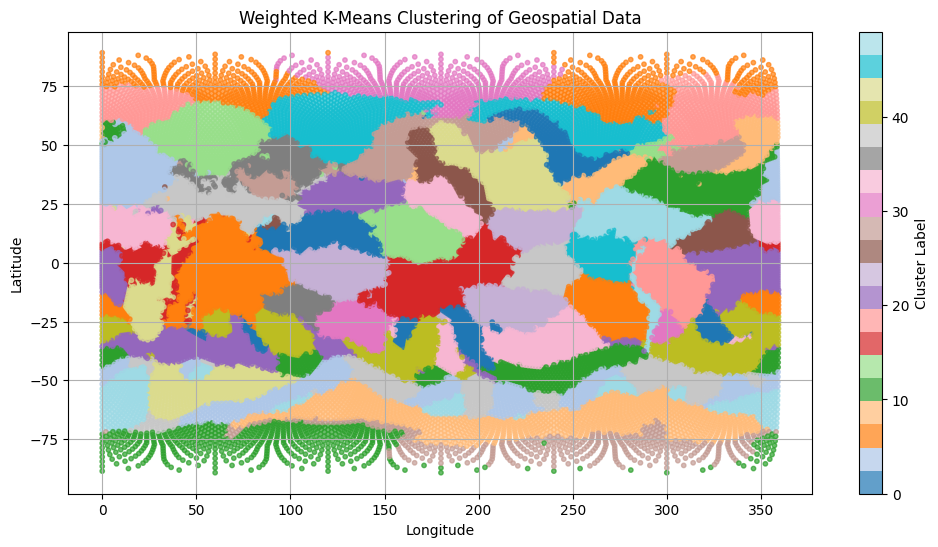

In [65]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
print(latent_mesh_nodes.shape)

# 标准化地理特征和嵌入特征
scaler_geo = StandardScaler()
geo_features = np.vstack((_mesh_nodes_lon, _mesh_nodes_lat)).T
geo_features_scaled = scaler_geo.fit_transform(geo_features)

scaler_latent = StandardScaler()
latent_features_scaled = scaler_latent.fit_transform(latent_mesh_nodes[:, 0, :])

# 合并地理特征和嵌入特征, 给予特征平衡
combined_features = np.hstack((geo_features_scaled, latent_features_scaled))

# 使用K-Means进行聚类
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(combined_features)

# 可视化聚类结果
plt.figure(figsize=(12, 6))
sc = plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, c=labels, cmap='tab20', s=10, alpha=0.7)
plt.title('Weighted K-Means Clustering of Geospatial Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(sc, label='Cluster Label')
plt.grid(True)
plt.show()


## 层次聚类（Hierarchical Clustering）

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# 仅使用经纬度聚类
geo_features = np.vstack((_mesh_nodes_lon, _mesh_nodes_lat)).T

# 选择要聚类的簇数目，例如100
num_clusters = 300

# 使用AgglomerativeClustering进行基于地理位置的聚类
clustering_model = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering_model.fit_predict(geo_features)

# 汇总每个簇内的嵌入，计算代表性嵌入
cluster_representatives = []
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_embeddings = latent_mesh_nodes[cluster_indices, 0, :]  # 提取集群内嵌入部分
    cluster_centroid = np.mean(cluster_embeddings, axis=0)  # 计算质心嵌入
    cluster_representatives.append(cluster_centroid)

# 将代表性嵌入转为数组
cluster_representatives = np.array(cluster_representatives)

# 可视化基于地理信息的聚类结果
plt.figure(figsize=(12, 6))
sc = plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, c=labels, cmap='tab20', s=10, alpha=0.7)
plt.title('Agglomerative Clustering of Geospatial Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.colorbar(sc, label='Cluster Label')
plt.grid(True)
plt.show()

# 可以选择打印或进一步处理每个簇的代表性嵌入
print("Cluster Representative Embeddings Shape:", cluster_representatives.shape)


In [9]:
predictions["2m_temperature"].isel(time=0).isel(batch=0)
output_grid_nodes.shape

(1038240, 1, 227)

# Prediction

<xarray.DataArray '2m_temperature' (lat: 721, lon: 1440)>
array([[248.66322, 248.66068, 248.66068, ..., 248.65813, 248.66068,
        248.65813],
       [248.66557, 248.65634, 248.65575, ..., 248.66452, 248.6725 ,
        248.66808],
       [248.37987, 248.3675 , 248.35739, ..., 248.38736, 248.37657,
        248.38301],
       ...,
       [248.32944, 248.35178, 248.33685, ..., 248.34871, 248.3628 ,
        248.35455],
       [248.02232, 248.02016, 248.02878, ..., 248.02255, 248.01274,
        248.01115],
       [247.57196, 247.57196, 247.56686, ..., 247.58725, 247.56686,
        247.57706]], dtype=float32)
Coordinates:
    time     timedelta64[ns] 06:00:00
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0


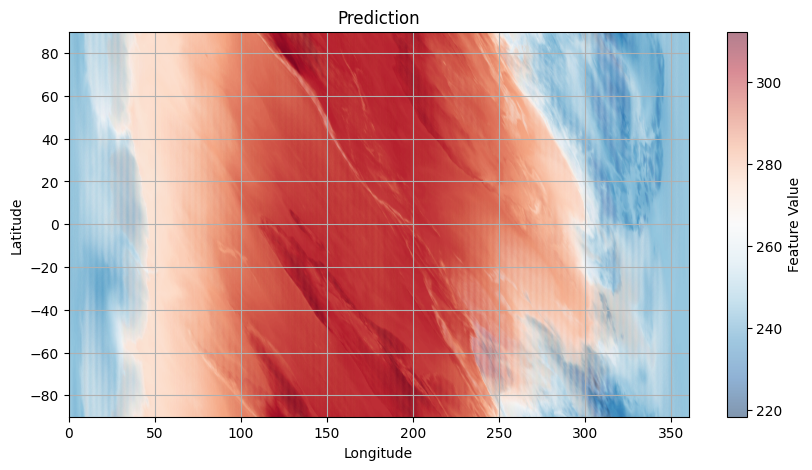

In [62]:
# 
feature_to_plot = predictions["2m_temperature"].isel(time=0).isel(batch=0)

print(feature_to_plot)

# 绘制散点图，并用颜色映射展示特征值
plt.figure(figsize=(10, 5))
sc = plt.scatter(flat_grid_lon, flat_grid_lat, c=feature_to_plot, cmap='RdBu_r', s=1, alpha=0.5)
plt.title('Prediction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.colorbar(sc, label='Feature Value')
plt.grid(True)
plt.show()